# Image Classification for 

### 1. Import dependencies

In [67]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything
from torchvision.models import resnet18, resnet34
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset

### 2. Load dataset

dataset was previously uploaded to huggingface. Please see upload_to_huggingface folder for workbook how-to.

In [25]:
dataset = load_dataset("marmal88/skin_cancer")
dataset.set_format(type='torch', columns=['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'])

# print to get the names of the sets within the dataset
print(dataset.__getitem__)

Using custom data configuration marmal88--skin_cancer-4d80d9330324f110
Found cached dataset parquet (/home/oem/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 3/3 [00:00<00:00, 124.64it/s]

<bound method DatasetDict.__getitem__ of DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 9577
    })
    test: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 1285
    })
    validation: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 2492
    })
})>


In [26]:
# load the respective train validation and test split to dataloader
train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset["validation"], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=32, shuffle=True)

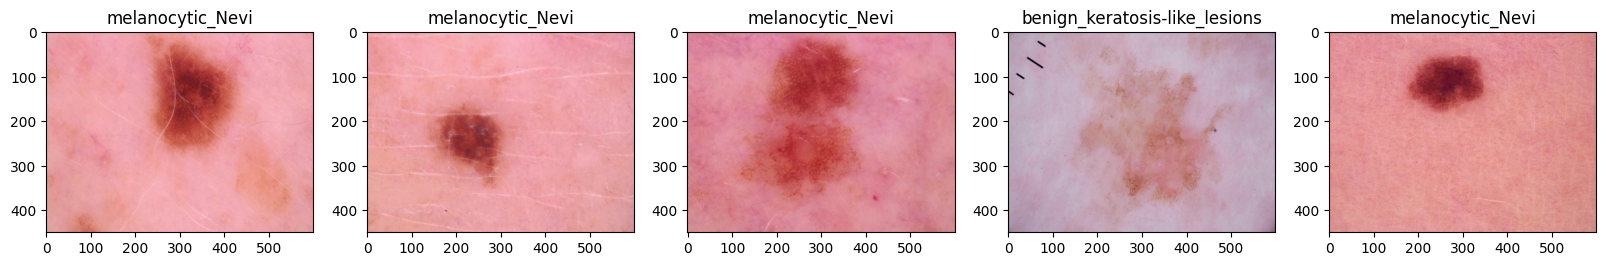

In [66]:
plt.figure(figsize=(20,20))

# viewing test dataset
# show the first image of the first 5 batches
for i in range(0, 5):
    batch = next(iter(train_loader))

    img, label = batch['image'], batch['dx']
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(label[1])
    plt.imshow(img[1])
plt.show()

### Using Pytorch Lightning

According to the offical PyTorch Lightning documentation, pl.model is organized into 5 main sections:

1. Computations (init).
2. Optimizers and LR Schedulers (configure_optimizers)
3. Train Loop (training_step)
4. Validation Loop (validation_step)
5. Test Loop (test_step)
6. Prediction Loop (predict_step)

In [ ]:
# create pytorch lightning module

class ClassifierModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        backbone = resnet34(weights="DEFAULT")
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = 10
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def optimizer(self):
        return Adam(self.parameters(), lr=0.001)
    

In [ ]:
model = ClassifierModel()
trainer = Trainer()
trainer.fit(model)

In [ ]:
model = ClassifierModel.load_from_checkpoint(PATH)
model.freeze()

x = some_images_from_cifar10()
predictions = model(x)